<a href="https://colab.research.google.com/github/DivyankR16/Deep_Learning/blob/main/Metaparameters/metaparamsWithBatchnorm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [14]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader,TensorDataset
from sklearn.model_selection import train_test_split
import numpy as np
import scipy.stats as stats
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib_inline.backend_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

In [17]:
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv"
data=pd.read_csv(url,sep=';')
data=data[data['total sulfur dioxide']<200]
colzscore=data.keys()
colzscore=colzscore.drop('quality')
data[colzscore]=data[colzscore].apply(stats.zscore)
data['boolQuality']=0
data['boolQuality'][data['quality']>5]=1
data

<ipython-input-17-0c6de309e151>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['boolQuality'][data['quality']>5]=1


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,boolQuality
0,-0.528350,0.960657,-1.391823,-0.452579,-0.244648,-0.464558,-0.382535,0.556807,1.288470,-0.580216,-0.959307,5,0
1,-0.298673,1.966614,-1.391823,0.049020,0.222827,0.877032,0.654661,0.025923,-0.723652,0.127837,-0.583341,5,0
2,-0.298673,1.295976,-1.185980,-0.165951,0.095334,-0.081247,0.246069,0.132100,-0.334209,-0.049176,-0.583341,5,0
3,1.653579,-1.386577,1.489975,-0.452579,-0.265897,0.110409,0.434650,0.662984,-0.983280,-0.462207,-0.583341,6,1
4,-0.528350,0.960657,-1.391823,-0.452579,-0.244648,-0.464558,-0.382535,0.556807,1.288470,-0.580216,-0.959307,5,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1594,-1.217380,0.401792,-0.980138,-0.380922,0.052836,1.547828,-0.068233,-0.982759,0.899027,-0.462207,0.074599,5,0
1595,-1.389638,0.122359,-0.877216,-0.237608,-0.542132,2.218623,0.151778,-0.865964,1.353377,0.599872,0.732539,6,1
1596,-1.159961,-0.101187,-0.722834,-0.165951,-0.244648,1.260344,-0.193954,-0.536815,0.704305,0.540868,0.544556,6,1
1597,-1.389638,0.653281,-0.774295,-0.380922,-0.265897,1.547828,-0.068233,-0.680154,1.677912,0.304850,-0.207376,5,0


In [21]:
dataT=torch.tensor(data[colzscore].values).float()
labels=torch.tensor(data['boolQuality'].values).float()
labels=labels[:,None]
print(dataT.shape)
print(labels.shape)

torch.Size([1597, 11])
torch.Size([1597, 1])


In [38]:
train_data,test_data,train_labels,test_labels=train_test_split(dataT,labels,test_size=0.1)
train_data=TensorDataset(train_data,train_labels)
test_data=TensorDataset(test_data,test_labels)
train_loader=DataLoader(train_data,batch_size=32,shuffle=True,drop_last=True)
test_loader=DataLoader(test_data,batch_size=test_data.tensors[0].shape[0],shuffle=True)

In [57]:
class ANNwine_withBNorm(nn.Module):
  def __init__(self):
    super().__init__()
    # input layer
    self.input=nn.Linear(11,16)
    # hidden layers
    self.fc1=nn.Linear(16,32)
    self.bnorm1=nn.BatchNorm1d(16)
    self.fc2=nn.Linear(32,20)
    self.bnorm2=nn.BatchNorm1d(32)
    # out layer
    self.output=nn.Linear(20,1)
  # forward pass
  def forward(self,x,isBnorm):
    x=F.relu(self.input(x))
    if isBnorm:
      x=self.bnorm1(x)
      x=self.fc1(x)
      x=F.relu(x)
      x=self.bnorm2(x)
      x=self.fc2(x)
      x=F.relu(x)
    else:
      x=F.relu(self.fc1(x))
      x=F.relu(self.fc2(x))
    return self.output(x)

In [58]:
def createModel():
  ANNmodel=ANNwine_withBNorm()
  lossfun=nn.BCEWithLogitsLoss()
  optimizer=torch.optim.SGD(params=ANNmodel.parameters(),lr=0.01)
  return ANNmodel,lossfun,optimizer

In [60]:
numepochs=1000
def trainModel(train_loader,test_loader,ANNmodel,lossfun,optimizer,isBnorm=True):
  train_acc=[]
  test_acc=[]
  losses=[]
  for epoch in range((numepochs)):
    ANNmodel.train()
    batchAcc=[]
    batchLoss=[]
    for X,y in train_loader:
      # forward pass
      yHat=ANNmodel(X,isBnorm)
      loss=lossfun(yHat,y)
      # backprop
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      # Calculations
      batchLoss.append(loss.item())
      batchAcc.append(100*torch.mean(((yHat>0)==y).float()).item())
    train_acc.append(np.mean(batchAcc))
    losses.append(np.mean(batchLoss))
    ANNmodel.eval()
    X,y=next(iter(test_loader))
    with torch.no_grad():
      yHat=ANNmodel(X,isBnorm)
    test_acc.append(100*torch.mean(((yHat>0)==y).float()).item())
  return train_acc,test_acc,losses

In [54]:
for X,y in train_loader:
  print(X.shape,end=' ')
  print(y.flatten().shape)

torch.Size([32, 11]) torch.Size([32])
torch.Size([32, 11]) torch.Size([32])
torch.Size([32, 11]) torch.Size([32])
torch.Size([32, 11]) torch.Size([32])
torch.Size([32, 11]) torch.Size([32])
torch.Size([32, 11]) torch.Size([32])
torch.Size([32, 11]) torch.Size([32])
torch.Size([32, 11]) torch.Size([32])
torch.Size([32, 11]) torch.Size([32])
torch.Size([32, 11]) torch.Size([32])
torch.Size([32, 11]) torch.Size([32])
torch.Size([32, 11]) torch.Size([32])
torch.Size([32, 11]) torch.Size([32])
torch.Size([32, 11]) torch.Size([32])
torch.Size([32, 11]) torch.Size([32])
torch.Size([32, 11]) torch.Size([32])
torch.Size([32, 11]) torch.Size([32])
torch.Size([32, 11]) torch.Size([32])
torch.Size([32, 11]) torch.Size([32])
torch.Size([32, 11]) torch.Size([32])
torch.Size([32, 11]) torch.Size([32])
torch.Size([32, 11]) torch.Size([32])
torch.Size([32, 11]) torch.Size([32])
torch.Size([32, 11]) torch.Size([32])
torch.Size([32, 11]) torch.Size([32])
torch.Size([32, 11]) torch.Size([32])
torch.Size([

In [61]:
ANNmodel,lossfun,optimizer=createModel()
train_accWithBnorm,test_accWithBnorm,lossesWithBnorm=trainModel(train_loader,test_loader,ANNmodel,lossfun,optimizer)
ANNmodel,lossfun,optimizer=createModel()
train_accWithoutBnorm,test_accWithoutBnorm,lossesWithoutBnorm=trainModel(train_loader,test_loader,ANNmodel,lossfun,optimizer,False)

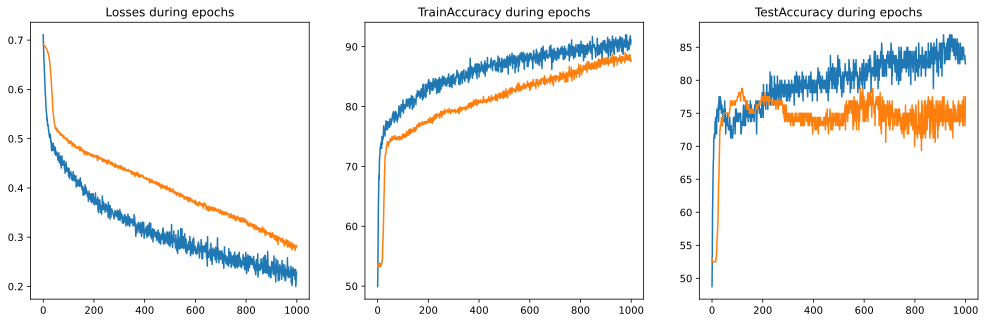

In [64]:
fig,ax=plt.subplots(1,3,figsize=(17,5))
ax[0].plot(lossesWithBnorm,label='With Bnorm')
ax[0].plot(lossesWithoutBnorm,label='Without Bnorm')
ax[0].set_title('Losses during epochs')
ax[0].legend

ax[1].plot(train_accWithBnorm,label='With Bnorm')
ax[1].plot(train_accWithoutBnorm,label='Without Bnorm')
ax[1].set_title('TrainAccuracy during epochs')
ax[1].legend

ax[2].plot(test_accWithBnorm,label='With Bnorm')
ax[2].plot(test_accWithoutBnorm,label='Without Bnorm')
ax[2].set_title('TestAccuracy during epochs')
ax[2].legend
plt.show()